## Imports

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# !unzip -uq "/content/drive/MyDrive/bazki/Images.zip" -d "/content/drive/MyDrive/bazy_danych"

## Dataset Exploration

In [ ]:
dataset = ImageFolder('/content/drive/MyDrive/bazy_danych/Images')
test_live_ds = ImageFolder('/content/drive/MyDrive/bazy_danych/testy_do_prezentacji')

In [ ]:
len(dataset)

20580

In [ ]:
len(dataset.classes)

120

In [ ]:
breeds = []

def rename(name):
    return ' '.join(' '.join(name.split('-')[1:]).split('_'))

for n in dataset.classes:
    breeds.append(rename(n))

## Creating training, validation and testing dataset

In [ ]:
random_seed = 45
torch.manual_seed(random_seed);

In [ ]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size


train_size, val_size, test_size

(12966, 1440, 6174)

In [ ]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

n02107908-Appenzeller
<class 'PIL.Image.Image'>


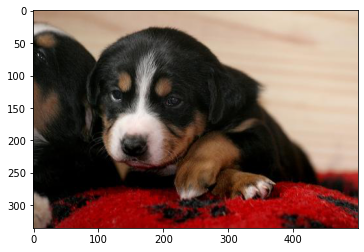

In [ ]:
img, label = train_ds[6]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

## Creating Custom Dataset

In [ ]:
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

In [ ]:

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    
])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

test_live_transform = transforms.Compose([
                      transforms.Resize((224,224)),
                      transforms.ToTensor(),
])

In [ ]:
train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)
test_live_dataset = DogBreedDataset(test_live_ds,test_live_transform)

Lets quickly take a look into our training dataset

89


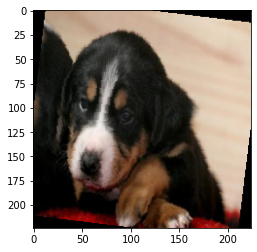

In [ ]:
img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

Now we will create Training , validation data and test data loader 

In [ ]:
batch_size =64

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_live_dl = DataLoader(test_live_dataset,batch_size/2,num_workers=2,pin_memory=True)

We can also take a peek into our dataset by creating grid of images using Pytorch's `make_grid()` method.

In [ ]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break

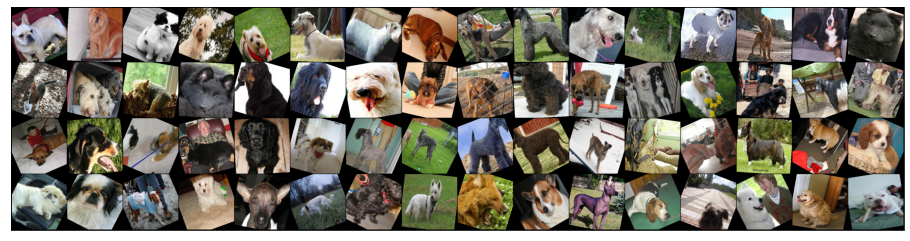

In [ ]:
show_batch(train_dl)

## Network Architecture

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))
        

In [ ]:
class DogBreedClassificationCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),   # 224 * 244 * 32
            nn.ReLU(),                                   
            nn.Conv2d(32, 32, 3, stride=1, padding=1),       
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # 112 * 112 * 32
            
            nn.Conv2d(32, 64, 3, stride=1, padding=1),   # 112 * 112* 64
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, stride=1, padding=1),    # 112 * 112* 128
            nn.ReLU(),
            nn.MaxPool2d(2,2),                          # 56 * 56* 128
            
            nn.Conv2d(128, 256, 3, stride=1, padding=1),   # 56*56*256
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),  # 56*56*256
            nn.ReLU(), 
            nn.MaxPool2d(2,2),                        # 28*28*256
            
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),                            # 14*14*256
            
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),                            # 7*7*256
            
            nn.Flatten(),
            nn.Linear(7*7*256, 512),
            nn.ReLU(),
            nn.Linear(512, 120),
            nn.LogSoftmax(dim = 1),
        )
    
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = DogBreedClassificationCNN()
model

DogBreedClassificationCNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): MaxPool2d(kernel_size=2, stride=2, p

Let's define ResNet-34 Pre-trained model

In [ ]:
class DogBreedPretrainedResnet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model2 = DogBreedPretrainedResnet34()
model2

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

DogBreedPretrainedResnet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

### Let's now use some more pre-trained models

Inception V3

In [ ]:
class DogBreedPretrainedInceptionV3(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.inception_v3(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
# model3 = DogBreedPretrainedInceptionV3()
# model3

Resnet 152

In [ ]:
class DogBreedPretrainedResnet152(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet152(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model4 = DogBreedPretrainedResnet152()
model4

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

DogBreedPretrainedResnet152(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

VGG16

In [ ]:
class DogBreedPretrainedVGG16(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.vgg16(pretrained=True)
        # Replace last layer  
        self.network.classifier = nn.Sequential(
           nn.Linear(in_features=25088, out_features=4096, bias=True),
           nn.ReLU(inplace=True),
           nn.Dropout(p=0.5, inplace=False),
           nn.Linear(in_features=4096, out_features=4096, bias=True),
           nn.ReLU(inplace=True),
           nn.Dropout(p=0.5, inplace=False),
           nn.Linear(in_features=4096, out_features=120, bias=True),
           nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model5 = DogBreedPretrainedVGG16()
model5

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

DogBreedPretrainedVGG16(
  (network): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

GoogleNet

In [ ]:
class DogBreedPretrainedGoogleNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.googlenet(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model6 = DogBreedPretrainedGoogleNet()
model6

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

DogBreedPretrainedGoogleNet(
  (network): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=Fa

DenseNet

In [ ]:
class DogBreedPretrainedDenseNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.densenet161(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.classifier.in_features
        self.network.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model7 = DogBreedPretrainedDenseNet()
model7

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

DogBreedPretrainedDenseNet(
  (network): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps

Wide ResNet-50-2

In [ ]:
class DogBreedPretrainedWideResnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.wide_resnet50_2(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model1 = DogBreedPretrainedWideResnet()
model1

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

DogBreedPretrainedWideResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsamp

## Moving Data to GPU

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [ ]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)


# moving model to gpu
to_device(model1, device);

cuda


## Training 

In [ ]:
# check the model 
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = model1(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break
        
try_batch(train_dl)

images shape :  torch.Size([64, 3, 224, 224])
labels :  tensor([ 53, 102,  12, 103,  61,   7,  27,  62,  59,  28,  10,  95,  19,  71,
         49,  50, 101,  44,  96,  63,  36,  49,   5,  22,   1,  97,  35,  20,
         16,  99, 119,  77,   7,  97, 107,  70,  51,  49,  22,  43,  73,   0,
         47,  42,  47,  85,  45,  12,  50,  30, 111,  42,  64,  37,  79,  51,
        110, 105,  36,  84,  13,  94, 117,  18], device='cuda:0')
outs.shape : torch.Size([64, 120])
outs :  tensor([[-4.5346, -4.5281, -4.7516,  ..., -5.1133, -4.9278, -4.6200],
        [-4.3224, -4.5686, -4.6873,  ..., -4.5427, -4.6315, -4.3251],
        [-4.1707, -4.5790, -4.7856,  ..., -4.9646, -5.0299, -4.6942],
        ...,
        [-4.5542, -4.3754, -4.8126,  ..., -4.8171, -4.6585, -4.7385],
        [-4.7110, -4.7906, -4.7739,  ..., -4.6483, -4.8659, -5.1702],
        [-4.4690, -4.8196, -4.6957,  ..., -5.0851, -4.8187, -4.6292]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


Now we'll train the model

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            # calculates gradients
            loss.backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
evaluate(model1, val_dl)           

{'val_loss': 4.852250576019287, 'val_acc': 0.010416666977107525}

In [ ]:
# set hyperparams
num_epochs = 5
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [ ]:
history = fit_one_cycle(num_epochs, max_lr, model1, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [0] : train_loss: 2.8247, val_loss: 1.0249, val_acc: 0.7122


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.7744, val_loss: 0.8635, val_acc: 0.7487


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.5262, val_loss: 0.7919, val_acc: 0.7630


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.3155, val_loss: 0.5500, val_acc: 0.8346


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.1678, val_loss: 0.4852, val_acc: 0.8561


In [ ]:
num_epochs = 3
max_lr = 0.001
history += fit_one_cycle(num_epochs, max_lr, model1, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.1384, val_loss: 0.4781, val_acc: 0.8607


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.1260, val_loss: 0.4765, val_acc: 0.8613


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.1197, val_loss: 0.4797, val_acc: 0.8607


In [ ]:
num_epochs = 2
max_lr = 0.0001
history += fit_one_cycle(num_epochs, max_lr, model1, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.1148, val_loss: 0.4738, val_acc: 0.8633


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.1069, val_loss: 0.4749, val_acc: 0.8639


## Plotting history

In [ ]:
history[0].keys()

dict_keys(['val_loss', 'val_acc', 'train_loss', 'lrs'])

In [ ]:
val_loss = []
train_loss = []
val_acc = []
time = list(range(len(history)))
for h in history:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])

### Loss v/s Epochs plot

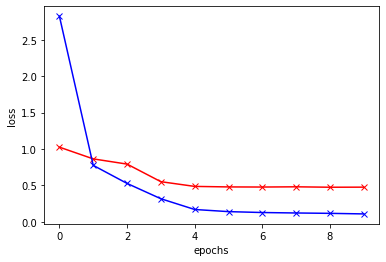

In [ ]:
plt.plot(time, val_loss, c='red', label='val_loss', marker='x')
plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### Accuracy v/s Epochs plot

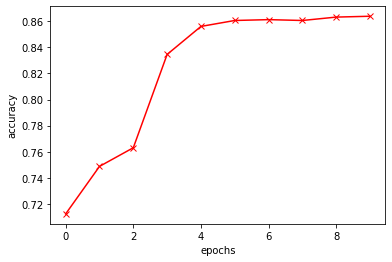

In [ ]:
plt.plot(time, val_acc, c='red', label='accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

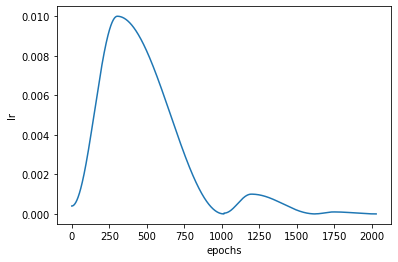

In [ ]:
lrs = np.concatenate([x.get('lrs', []) for x in history])
plt.xlabel('epochs')
plt.ylabel('lr')
plt.plot(lrs)
plt.show()

## Prediction

In [ ]:
def predict_single(img, label):
    xb = img.unsqueeze(0) # adding extra dimension
    xb = to_device(xb, device)
    preds = model1(xb)# change model object here
    predictions = preds[0]
    
    max_val, kls = torch.max(predictions, dim=0)
    print('Actual :', breeds[label], ' | Predicted :', breeds[kls])
    plt.imshow(img.permute(1,2,0))
    plt.show()

In [ ]:
for inputs, labels in test_live_dl:
    outputs = model1(inputs)
_, preds = torch.max(outputs, 1)

ValueError: ignored

In [ ]:
print(test_live_dl)

Actual : African hunting dog  | Predicted : African hunting dog


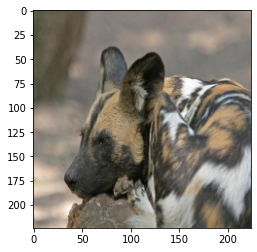

In [ ]:
predict_single(*test_dataset[6])

Actual : EntleBucher  | Predicted : EntleBucher


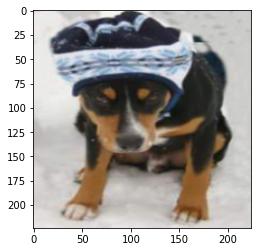

In [ ]:
predict_single(*test_dataset[26])

Actual : Gordon setter  | Predicted : Gordon setter


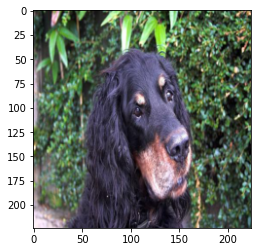

In [ ]:
predict_single(*test_dataset[17])

Actual : wire haired fox terrier  | Predicted : wire haired fox terrier


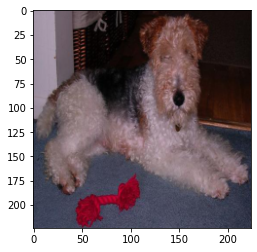

In [ ]:
predict_single(*test_dataset[1158])

In [ ]:
# predict_example(test_live_dataset[2])

In [ ]:
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
result = evaluate(model1, test_dl)
result

{'val_loss': 0.459516316652298, 'val_acc': 0.8581207394599915}

## Save model

In [ ]:
# weights_fname = '/content/drive/MyDrive/bazy_danych/dog-breed-classifier-wideresnet_with_data_aug.pth'
# torch.save(model4.state_dict(), weights_fname)

In [ ]:
# examples = ImageFolder('/content/drive/MyDrive/bazy_danych/Images/test_do_prezentacji')